Analyze the progression of the frontier points algorithm with temperature change


In [1]:
pwd

'/Users/zofia/github/DFM/interactivePython'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import integrator
import sampler #as sampler
import model #as model
import diffusionmap as dm
import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
from openmmtools.constants import kB

import model
mdl=model.Model('Alanine')
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
print (mdl.testsystem.positions)
X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)
print('Initial distance is %f' % np.linalg.norm(X0[0,:]-X0[ 1,:]))

print(mdl.kB_const)

algoVect=0

# parameters
# this is the target temperature 
T=300.0
temperature =  T * unit.kelvin
kT = kB * temperature


gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

TemperatureTAMDFactor=30.0
massScale=50.0

gammaScale=100.0
kappaScale=1000.0

print("TemperatureTAMDFactor = " + repr(TemperatureTAMDFactor))
temperatureAlpha= (T*TemperatureTAMDFactor)* unit.kelvin

print('Gamma is '+repr(gamma))
print('Temperature is '+repr(temperature))
print('Temperature TAMD '+repr(TemperatureTAMDFactor)+'xTemperature')
print('Mass alpha is '+repr(massScale)+'x Mass')



# simulation class sampler takes integrator class with chosen parameters as input
integrator=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, temperatureAlpha=temperatureAlpha, dt=dt, massScale=massScale, gammaScale=gammaScale, kappaScale=kappaScale)
smpl=sampler.Sampler(model=mdl, integrator=integrator, algorithm=0, dataFileName='Data')




nanometer
System has 22 particle(s)
[[  2.00000100e-01   1.00000000e-01  -1.30000000e-07]
 [  2.00000100e-01   2.09000000e-01   1.00000000e-08]
 [  1.48626400e-01   2.45384900e-01   8.89824000e-02]
 [  1.48625900e-01   2.45385200e-01  -8.89820000e-02]
 [  3.42742000e-01   2.64079500e-01  -3.00000000e-07]
 [  4.39058000e-01   1.87740600e-01  -6.60000000e-07]
 [  3.55537540e-01   3.96964880e-01  -3.10000000e-07]
 [  2.73312000e-01   4.55616010e-01  -1.30000000e-07]
 [  4.85326210e-01   4.61392530e-01  -4.30000000e-07]
 [  5.40759600e-01   4.31553880e-01   8.89815200e-02]
 [  5.66130440e-01   4.22084250e-01  -1.23214800e-01]
 [  5.12326150e-01   4.52136300e-01  -2.13120160e-01]
 [  6.63048400e-01   4.71893540e-01  -1.20579070e-01]
 [  5.80854010e-01   3.14087240e-01  -1.24138500e-01]
 [  4.71267590e-01   6.12941850e-01   1.40000000e-07]
 [  3.60064450e-01   6.65270270e-01   6.20000000e-07]
 [  5.84605330e-01   6.83488330e-01   2.50000000e-07]
 [  6.73700140e-01   6.35916200e-01  -4.000000

In [3]:
methodName =  'T300/Std'# 'corner_temperature_change_off'# 'frontier_points_corner'

numberOfIterations=1360

import pyemma.coordinates as coor
feat = coor.featurizer(md.Topology().from_openmm(smpl.model.testsystem.topology))
feat.add_backbone_torsions()

inp=coor.load('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Trajshort/traj_reference_short.h5', feat) 
print( np.asarray(inp).shape)


(136800, 2)


/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


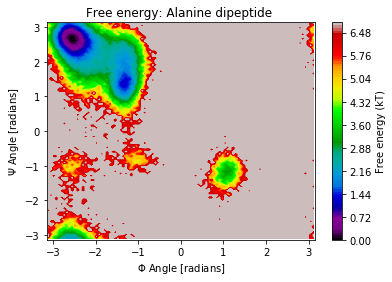

In [4]:
import pyemma.plots as mplt
from math import pi
   
Y = inp   
   
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
#plt.savefig('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/freeEnergy.png', dpi='figure', bbox_inches='tight')

plt.show()
   

In [5]:
#'/Users/zofia/github/DFM/Data/Std/Traj/*.h5'


#---------------- load trajectories: for example from simulation at higher temperature
import glob



def loadData(fileName, iteration=False):
    print('Loading data from '+ fileName)
    numpy_vars = []
    
    print(fileName+'*.h5')
    if iteration== False:
        
        for np_name in glob.glob(fileName+'*.h5'):
            numpy_vars.append(md.load(np_name))
    else:
        for np_name in glob.glob(fileName):
            numpy_vars.append(md.load(np_name))

    traj = numpy_vars
    print(len(traj))

    Xmdtraj=list()
    for i in range(len(traj)):
        #print(traj[i][0].xyz)
        Xmdtraj.append(md.Trajectory(traj[i].xyz, smpl.model.testsystem.topology))#mdl.testsystem.topology) )

    print(Xmdtraj[0].xyz.shape[2])
    L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
    nrP=int(Xmdtraj[0].xyz.shape[1])
    print(nrP)
    D=int(Xmdtraj[0].xyz.shape[2])
    X=np.zeros((L, nrP, D))
    for i in range(0,len(Xmdtraj)):
            X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz
    
    Xmdtraj = md.Trajectory(X, mdlTopology )
    
    return X, traj, Xmdtraj


In [77]:
nameData = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Trajshort/'

X_FT, traj_FT, Xmdtraj_FT = loadData(nameData)


Loading data from /Users/zofia/github/DFM/Data/Alanine/T300/Std/Trajshort/
/Users/zofia/github/DFM/Data/Alanine/T300/Std/Trajshort/*.h5
1
3
22


In [78]:
# print(X_FT.shape)
# top=md.Topology().from_openmm(smpl.model.testsystem.topology)
# Xmdtrajshort=md.Trajectory(np.asarray(X_FT[::10,:,:]), top)  
# nameDataShort = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Trajshort/'
# Xmdtrajshort.save(nameDataShort+'traj_reference_short.h5')

In [79]:
X_FT=X_FT[::10]

Xresh = X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])
print('Data size')
print(Xresh.shape)


Data size
(13680, 66)


In [80]:


import imp
imp.reload(dm)
epsilon=0.1
Xresh=Xresh#*smpl.model.x_unit


print('Compute kernel')
kernel_all=dm.compute_kernel(Xresh, epsilon, myMetric = 'euclidean')
print('Kernel computation done')

# ### or use the nearest neighbors

# import kernel as krnl
# kernel = krnl.Kernel()

# print('Initialize kernel')
# kernel.fit(Xresh)
# print('Compute kernel')
# kernel_all = kernel.compute(Xresh)
# print('Kernel computation done')


Compute kernel
constructing neighbors graph
neighbors graph done
Kernel computation done


In [81]:
print('Compute KDE')
print(kernel_all.shape[0])
qEmp=kernel_all.sum(axis=1)/kernel_all.shape[0]/(epsilon)
print(np.sum(qEmp))

Compute KDE
13680
12.1117266997


In [82]:
### use sklearn density
# import sklearn.neighbors as skl
# skl_kernel_density =skl.KernelDensity(bandwidth=0.001)
# skl_kernel_density.fit(Xresh)
# qskl=np.exp(skl_kernel_density.score_samples(Xresh))
# print(Xresh.shape)
# print(qskl.shape)
# print(np.sum(qskl))
# qEmp=qskl/np.sum(qskl)
# print('Kernel computation done')

In [83]:
# import imp
# imp.reload(dm)
# print('Compute kernel')

# X_FT=X_FT[::100]
# #Xresh = X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])
# #Xresh=Xresh*smpl.model.x_unit
# kernel = dm.compute_kernel(X_FT, 1.0, metric=dm.myEuclideanMetric)

# print('Compute KDE')
# qEmp=kernel_all.sum(axis=1)



In [84]:
# import imp
# imp.reload(dm)
# Y=X_FT[:10]

# Xresh = Xsp_FT.reshape(Xsp_FT.shape[0], Xsp_FT.shape[1]*Xsp_FT.shape[2])

# Y=Y.reshape(Y.shape[0], Y.shape[1]* Y.shape[2])
# print(Y.shape)
# vy=np.vstack([Xresh, Y])
# data=Xresh
# print(data.shape)
# kernel_extended = dm.compute_kernel(vy, 1.0)
# print(kernel_extended.shape)
# kernel_extended = kernel_extended[:data.shape[0], :vy.shape[0]]
# print(kernel_extended.shape)


# print(kernel_extended.transpose().shape)
# print(V1_FT.shape)

# # TODO: need to save lambdas-> see other notebook
# #V1= np.dot(V1_FT,np.power(lambdas[1],-1))

# xsum=kernel_extended.transpose() * V1 / lambdas[1]#
# print(xsum.shape)
# V1_ext = xsum

# plt.scatter(range(len(V1)), np.abs(V1-V1_ext[:len(V1)]))
# plt.show()
# # print(vy.shape)
# # dm.compute_extended_P(Y, Xresh, kernel_all, 1.0)

In [85]:
print(smpl.integrator.kT)

2494.341741366065 J/mol


In [ ]:
print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""
from simtk import unit

tr=X_FT#Xresh

qTargetDistribution=np.zeros(len(tr))
E=np.zeros(len(tr))
for i in range(0,len(tr)):
            tmp=tr[i]#.reshape(smpl.model.testsystem.positions.shape)#*smpl.model.x_unit
            #E[i]=smpl.model.energy(tmp) #/ smpl.model.energy_unit
            #print(tmp)
            Etmp= smpl.model.energy(tmp)
            
            #print(Etmp)
            betatimesH_unitless =Etmp / smpl.kT #* smpl.model.temperature_unit 
            qTargetDistribution[i]=np.exp(-(betatimesH_unitless))
            #print(betatimesH_unitless)
            E[i]=Etmp.value_in_unit(smpl.model.energy_unit)
            
print('Done')

qTargetDistributionNormalized=qTargetDistribution/np.sum(qTargetDistribution)

plt.hist(E, 1000)
plt.title('Histogram Energy')
plt.show()

print(qTargetDistribution.shape)


Get the target density at sampled data points
... might take a while ...


In [ ]:
idx=10


qTargetDistributionNormalized=qTargetDistribution

print('Value at point with index ' +repr(idx))
print('Energy '+repr(E[idx]))
print('KDE: '+repr(qEmp[idx]))
print('Target density(normalized):'+repr(qTargetDistribution[idx]))


def computeWeights(t, q):
    w=np.zeros(len(t))
    for i in range(len(t)):
        #if(q[i]>10**(-10)):
            w[i] = t[i]/q[i]
        #else:
        #    w[i] = 0.0
        
            
    return w


print('Sum qEmp is '+repr(np.sum(qEmp)))
weight=computeWeights(qTargetDistributionNormalized, qEmp)
print('Sum weights is '+repr(np.sum(weight)))
print('mean weight is '+repr(np.mean(weight)))
print('sum weight is '+repr(np.sum(weight)))
print('max weight is '+repr(np.max(weight)))
print('min weight is '+repr(np.min(weight)))
print('Max error is '+repr(np.max(np.abs(qTargetDistributionNormalized-qEmp))))
print('Mean error is '+repr(np.mean(np.abs(qTargetDistributionNormalized-qEmp))))

In [ ]:

# for i in range(len(weight)):
#     if(np.abs(weight[i])<10**(-10)):
#         weight[i]=0
#     if(np.abs(weight[i])>10**(2)):
#         weight[i]=0
        
# print(len(np.where(weight>10**3)[0]))

In [ ]:
psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
top=md.Topology().from_openmm(smpl.model.testsystem.topology)
    
            
inp=md.Trajectory(X_FT, top)

Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 

Qest = qEmp
qT = qTargetDistributionNormalized

plt.scatter(np.vstack(Y)[:,0], qT, s=5, c='b')
#plt.scatter(np.vstack(Y)[:,0], Qest/np.mean(Qest), s=5, c='r')
plt.xlabel('Psi')
plt.ylabel('Density')
plt.legend(['Target','KDE'])

plt.show()


#plt.scatter(np.vstack(Y)[:,0], qT/np.mean(qT), s=5, c='b')
plt.scatter(np.vstack(Y)[:,0], Qest, s=5, c='r')
plt.xlabel('Psi')
plt.ylabel('Density')
plt.legend(['KDE'])

plt.show()


plt.scatter(np.vstack(Y)[:,0], qT, s=5, c='b')
plt.scatter(np.vstack(Y)[:,0], Qest, s=5, c='r')
plt.xlabel('Psi')
plt.ylabel('Density')
plt.legend(['Target','KDE'])

plt.show()


plt.scatter(np.vstack(Y)[:,0], weight, s=5)
plt.xlabel('Psi')
plt.ylabel('Weights')

plt.show()

plt.scatter(np.vstack(Y)[:,1], weight, s=5)
plt.xlabel('Phi')
plt.ylabel('Weights')

plt.show()

print('Mean weigth is '+repr(np.mean(weight)))

In [ ]:
#-----------average energy
# meanV = stat.computeAverages(Xsp_FT, samplerAlgo.model.energy, units=samplerAlgo.model.energy_unit)
# meanVunbiased = stat.computeUnbiasedAverages(Xsp_FT, samplerAlgo.model.energy, weight, units=samplerAlgo.model.energy_unit)
import imp
imp.reload(stat)

Xsp_FT=X_FT

# meanV = stat.computeAverages(Xsp_FT, smpl.model.energy, units=smpl.model.energy_unit, vectorFunction=False)
# meanVunbiased = stat.computeUnbiasedAverages(Xsp_FT, smpl.model.energy, weight, units=smpl.model.energy_unit,  vectorFunction=False)

meanV = stat.computeAverages(Xsp_FT, E, units=1, vectorFunction=True)
meanVunbiased = stat.computeUnbiasedAverages(Xsp_FT, E, weight, units=1,  vectorFunction=True)


print('Raw:')
print('<V> = '+repr(meanV*smpl.model.energy_unit))

print('\nUnbiased:')
print('<V> = '+repr(meanVunbiased*smpl.model.energy_unit))


#Reference averages at 300K:
#<V> = Quantity(value=-23.990307294355031, unit=kilojoule/mole)


In [ ]:
top=md.Topology().from_openmm(smpl.model.testsystem.topology)
#---------- average rmsd

# #print(Xmdtraj_FT[0].xyz)
def computeRMSD(Xmdtraj_FT):
    rmsd=np.zeros(len(Xmdtraj_FT))
    for i in range(len(Xmdtraj_FT)):
        rmsd[i]= md.rmsd(Xmdtraj_FT[0], Xmdtraj_FT[i])

    return rmsd


#give the rmsd vector
rmsdShort=computeRMSD(md.Trajectory(X_FT,top))

meanR = stat.computeAverages(X_FT, rmsdShort, vectorFunction=True)
meanRunbiased = stat.computeUnbiasedAverages(X_FT, rmsdShort, weight, vectorFunction=True)

print('Raw:')
print('<rmsd> = '+repr(meanR*smpl.model.x_unit))

print('\nUnbiased:')
print('<rmsd> = '+repr(meanRunbiased*smpl.model.x_unit))

#Reference averages at 300K:
#<rmsd> = Quantity(value=0.13858858377493002, unit=nanometer)



In [ ]:
maxValEnergy=15

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
top=md.Topology().from_openmm(smpl.model.testsystem.topology)
print(weight.shape)
            
inp=md.Trajectory(X_FT, top)

Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
angles=Y

######### raw

mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1],   kT=2.494, vmin=0, vmax=maxValEnergy,avoid_zero_count=False);
plt.title('Raw: Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
plt.show()

######### weights

fepyemma = mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], weights=weight,  kT=2.494 , vmin=0, vmax=maxValEnergy,avoid_zero_count=False);
plt.title('Weigths: Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
plt.show()

######### reference
  
inpRef = np.load('/Users/zofia/github/DFM/Data/Alanine/T300/Std/dihedrals_reference_data.npy')


mplt.plot_free_energy(np.vstack(inpRef)[:,0], np.vstack(inpRef)[:,1], kT=2.494,  vmin=0, vmax=maxValEnergy,avoid_zero_count=False);
plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
plt.show()

print('Number of reference points is '+repr(inpRef.shape[0]*inpRef.shape[1]))
print('Number of sampled points is '+repr(Y.shape[0]))

In [ ]:
# #weight = qT[:10] /Qest[:10]# (qT/np.mean(qT))/ Qest/np.mean(Qest)
# weight, Nt =stat.compute_weight_target_distribution( qT, Qest)
# print(weight.shape)
# weight= weight*Nt#np.sum(Qest) / np.sum(qT)



In [ ]:
def histogramFreeEnergy(angles, weights = weight, kT=1):
    

    nrbins=200
    FplotPhi=np.zeros(( nrbins))
    FplotPsi=np.zeros(( nrbins))


    Y=angles
    minx=np.min(Y[:,0])
    maxx=np.max(Y[:,0])
    miny=np.min(Y[:,1])
    maxy=np.max(Y[:,1])


    xd=np.linspace(minx, maxx, num=nrbins)
    yd=np.linspace(miny, maxy, num=nrbins)
    
    if weights == None:
        H,x,y = np.histogram2d(Y[:,0], Y[:,1], bins=nrbins, weights=None, normed=True)
    else:
        H,x,y = np.histogram2d(Y[:,0], Y[:,1], bins=nrbins, weights=weight, normed=True)
    
    #avoid zeros
    
    # compute free energies
#     Hminzero = np.min(H[np.where(H > 0)])
#     H = np.maximum(H, Hminzero)
    F = -kT*np.log(H)

    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    xticks(np.arange(int(minx), int(maxx)+1, 1))
    yticks(np.arange(int(miny), int(maxy)+1, 2))
    plt.contourf(F.T, 50, cmap=plt.cm.spectral, extent=extent)
    cbar=colorbar()
    cbar.set_label('Free Energy [kJ]')
    xlabel(r'$\Phi$ Angle [radians]')
    xlim(-pi, pi)
    ylabel(r'$\Psi$ Angle [radians]')
    ylim(-pi, pi)
    if weights == None:
        plt.title('Raw')
        w=1
        wght=1
    else:
        plt.title('Weights')
        w=np.sum(weight)
        wght=weight
    plt.show()

    FplotPhi=-np.log(np.mean(H, axis=1)) 
    FplotPsi=-np.log(np.mean(H, axis=0)) 
    
#     if weights == None:
#         w=1#np.ones(len(Y))
#     else:
#         w=np.mean(weight)
    
#     FplotPhi=np.mean(F.T, axis=1)
#     FplotPsi=np.mean(F.T, axis=0)

    
    
    
    return FplotPhi, FplotPsi, xd



def histogramFreeEnergyPsi(angles, phiPsi, weights = weight, kT=1):
    

    nrbins=200
    FplotPhi=np.zeros(( nrbins))
    
    Y=angles
    minx=np.min(Y[:,phiPsi])
    maxx=np.max(Y[:,phiPsi])
    

    xd=np.linspace(minx, maxx, num=nrbins)
    
    
    if weights == None:
        H,x = np.histogram(Y[:,phiPsi], bins=nrbins, weights=None, normed=True)
    else:
        H,x = np.histogram(Y[:,phiPsi], bins=nrbins, weights=weight, normed=True)
    
    FplotPhi = -kT*np.log(H)
  
    
    
    return FplotPhi, xd

In [ ]:
%pylab inline

#################

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
top=md.Topology().from_openmm(smpl.model.testsystem.topology)
    
            
inp=md.Trajectory(X_FT, top)

angles_raw = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
angles_ref =inpRef.reshape(inpRef.shape[0]*inpRef.shape[1],inpRef.shape[2])# md.geometry.compute_dihedrals(inpRef, [phi_indices, psi_indices])

cl=angles_raw.shape[0]
#angles_ref = angles_ref[:cl,:]
#angles_ref = angles_ref[::100,:]

print('Data size:')
print(len(angles_raw))
print(len(angles_ref))
###################

# reference values - free energies are recomputed again to check normalizations, the data below was computed while postprocessing the reference simulation

# FplotPhi_ref = np.load('/Users/zofia/github/DFM/Data/Alanine/T300/Std/FreeEnergy_Phi_reference300K.npy')
# FplotPsi_ref = np.load('/Users/zofia/github/DFM/Data/Alanine/T300/Std/FreeEnergy_Psi_reference300K.npy')
# xd_ref = np.load('/Users/zofia/github/DFM/Data/Alanine/T300/Std/FreeEnergy_Grid_reference300K.npy')

weightNorm=weight#/np.sum(weight)
#print(weight)
###
print('Enhanced raw')
FplotPhi, FplotPsi, xd = histogramFreeEnergy(angles_raw, weights = None, kT = 2.494)

# FplotPhi, xd = histogramFreeEnergyPsi(angles_raw, 0, weights = None, kT = 2.494)
# FplotPsi, xd = histogramFreeEnergyPsi(angles_raw, 1, weights = None, kT = 2.494)

print('Enhanced weights')
FplotPhi_weight, FplotPsi_weight, xd = histogramFreeEnergy(angles, weights = weightNorm, kT = 2.494)

# FplotPhi_weight, xd = histogramFreeEnergyPsi(angles_raw, 0, weights = weight, kT = 2.494)
# FplotPsi_weight, xd = histogramFreeEnergyPsi(angles_raw, 1, weights = weight, kT = 2.494)

print('Reference raw')
FplotPhi_ref, FplotPsi_ref, xd = histogramFreeEnergy(angles_ref, weights = None, kT = 2.494)

# FplotPhi_ref, xd = histogramFreeEnergyPsi(angles_ref, 0, weights = None, kT = 2.494)
# FplotPsi_ref, xd = histogramFreeEnergyPsi(angles_ref, 1, weights = None, kT = 2.494)
###############################

plt.plot(xd, FplotPhi_ref,  c='r')
plt.plot(xd, FplotPhi,  c='b')
plt.plot(xd, FplotPhi_weight,  c='g')
    
minY=0
maxY=15
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.ylabel(r'Free Energy [kJ]')
#plt.ylim(minY, maxY)
plt.legend(['Reference','Enhanced raw', 'Enhanced weight'], bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.5)
plt.savefig('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/freeEnergyAnglePhi_comparison.png', dpi='figure', bbox_inches='tight')
plt.show()

###############################
plt.plot(xd, FplotPsi_ref, c='r')
plt.plot(xd, FplotPsi, c='b')
plt.plot(xd, FplotPsi_weight, c='g')

plt.xlabel(r'$\Psi$ Angle [radians]')
plt.ylabel(r'Free Energy [kJ]')
plt.legend(['Reference','Enhanced raw', 'Enhanced weight'], bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.5) 

plt.show()
